#### Install 'pdarima' library

In [1]:
# pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

#### Prepare dataset

In [3]:
df = pd.read_csv('./AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])

- source: https://community.qlik.com/t5/Qlik-Sense-Documents/AirPassengers-csv/ta-p/1476807

#### Plot data

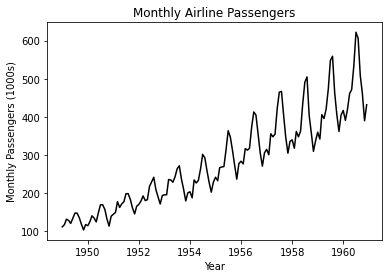

In [4]:
fig, ax = plt.subplots()
plt.xlabel('Year')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Airline Passengers')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#### Split data

- Training dataset: 1949 to 1957
- Test dataset: 1958 to  1960

In [5]:
trn = df.loc[df.index < '1958-01-01']
tst = df.loc[df.index >= '1958-01-01']

#### Plot the training data.

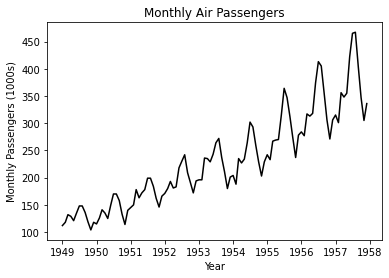

In [6]:
fig, ax = plt.subplots()
plt.xlabel('Year')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Air Passengers')
plt.plot(trn, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#### Plot testing data

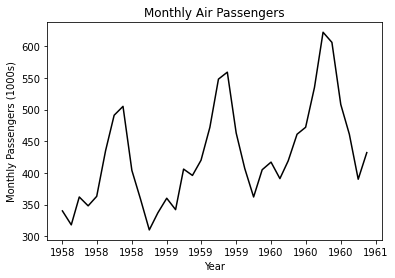

In [7]:
fig, ax = plt.subplots()
plt.xlabel('Year')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Air Passengers')
plt.plot(tst, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#### Test Stationarity

- Since ARIMA requires non-stationary data, we test stationarity

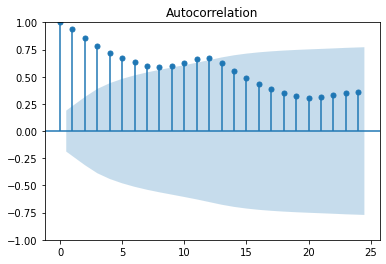

In [8]:
trn_acf = plot_acf(trn, lags=24)

#### Linear Model

- Fit a linear regression model

In [9]:
lr = sm.OLS(endog=trn['#Passengers'], exog=sm.add_constant(np.arange(1, 1 + trn.shape[0]))).fit() 
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           6.40e-43
Time:                        19:15:15   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

- Extract the fitted values.

In [10]:
y_hat = lr.fittedvalues

- Extract the 95% prediction interval.

In [11]:
y_ci = lr.get_prediction().conf_int(alpha=0.05)

#### Graph for time series with linear regression line and corresponding 95% prediction interval

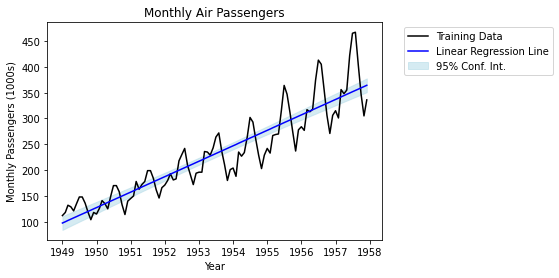

In [12]:
fig, ax = plt.subplots()
plt.xlabel('Year')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Air Passengers')
plt.plot(trn, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#### ARIMA

- Find the best ARIMA order using the 'auto_arima'.

In [13]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)


In [14]:
print(auto_arima_model.summary())
auto_arima_model.order

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Tue, 12 Oct 2021   AIC                            704.001
Time:                                    19:15:18   BIC                            709.109
Sample:                                         0   HQIC                           706.065
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

(1, 1, 0)

- AR order = 1, I order = 1, MA order = 0

In [15]:
auto_arima_model.seasonal_order
# (P,D,Q,M) Order for seasonal component, D = 1 is the degree of differencing 
#of seasonal component and M= 12 indicates periodicity

(0, 1, 0, 12)

#### Plot the standardized residuals.

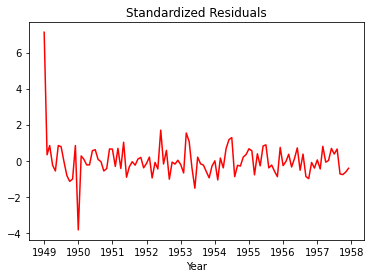

In [16]:
resid = auto_arima_model.resid()
fig, ax = plt.subplots()
plt.plot(trn.index, stats.zscore(resid), color='red')
plt.title('Standardized Residuals')
plt.xlabel('Year')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#### Plot the ACF (autocorrelation function) of the residuals. 

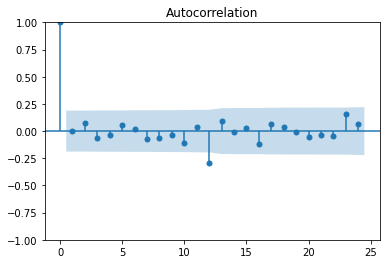

In [17]:
res_acf = plot_acf(resid, lags=24)

#### Plot the p-values of the Ljung-Box test for autocorrelation.

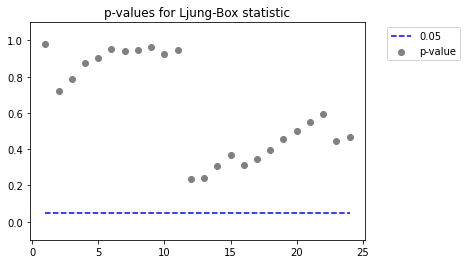

In [18]:
res_lb = acorr_ljungbox(resid, lags=24, return_df=False)[1]
fig, ax = plt.subplots()
plt.title('p-values for Ljung-Box statistic')
plt.scatter(np.arange(1, 1 + len(res_lb)), res_lb, color='gray', label='p-value')
plt.plot(np.arange(1, 1 + len(res_lb)), [0.05] * len(res_lb), '--', color='blue', label='0.05')
plt.ylim(-0.1, 1.1)
plt.legend(bbox_to_anchor=(1.3, 1))

#### Fit the best model to the training data.

In [19]:
auto_arima_model.fit(trn)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

#### Predict the intervals for last three years

In [20]:
arima_predictions = auto_arima_model.predict(n_periods=36, alpha=0.05, return_conf_int=True)
y_pred = pd.Series(arima_predictions[0], index=tst.index)

#Extract the 95% prediction interval.
y_pred_lb, y_pred_ub = arima_predictions[1][:, 0], arima_predictions[1][:, 1]

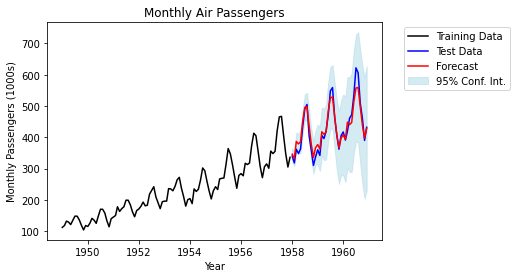

In [21]:
fig, ax = plt.subplots()
plt.xlabel('Year')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Air Passengers')
plt.fill_between(tst.index, y_pred_lb, y_pred_ub, color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.plot(trn, color='black', label='Training Data')
plt.plot(tst, color='blue', label='Test Data')
plt.plot(y_pred, color='red', label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#### Printing with Confidence Intervals

In [22]:
tst_pred = pd.DataFrame({
    'Actual': tst.iloc[:, 0].values, 
    'Point Forecast': y_pred.values, 
    'Lo 95': y_pred_lb,
    'Hi 95': y_pred_ub
    }, index=tst.index)

In [23]:
tst_pred.head()

,Actual,Point Forecast,Lo 95,Hi 95
Month,,,,
1958-01-01,340,345.964471,327.088699,364.840243
1958-02-01,318,331.731920,308.036230,355.427610
1958-03-01,362,386.787992,358.515740,415.060244
1958-04-01,348,378.774472,346.695454,410.853490
1958-05-01,363,385.777732,350.270764,421.284700
